In [62]:
import tqdm as tqdm
import voicing as vc
from tqdm import tqdm
import importlib
import formats as fmt
import numpy as np
import json

In [63]:
#Load dataset

with open('../data/formatted/meta_dataset.txt', 'r') as jsonFile:
    meta_augmented = json.load(jsonFile)
    
with open('../data/formatted/dataset_augmented.txt', 'r') as jsonFile:
    dataset_augmented = json.load(jsonFile)
    
with open('../data/formatted/midi_voicing_dataset.txt', 'r') as jsonFile:
    midi_voicing_dataset = json.load(jsonFile)

print(len(midi_voicing_dataset), len(dataset_augmented), len(meta_augmented))

48072 48072 48072


In [64]:
print(midi_voicing_dataset[4567])

[[[0, 0, 0, 0, 0, 0, 0, 0], 0.0, '<style>'], [[0, 0, 0, 0, 0, 0, 0, 0], 0.0, 'Ballad'], [[0, 0, 0, 0, 0, 0, 0, 0], 0.0, '|'], [[0, 0, 0, 0, 0, 0, 0, 0], 2.0, '.'], [[43, 0, 0, 0, 0, 0, 0, 0], 2.0, 'G'], [[43, 54, 59, 62, 0, 0, 0, 0], 2.0, 'maj7'], [[0, 0, 0, 0, 0, 0, 0, 0], 2.0, '.'], [[54, 0, 0, 0, 0, 0, 0, 0], 2.0, 'F#'], [[54, 58, 62, 66, 70, 0, 0, 0], 2.0, 'aug'], [[0, 0, 0, 0, 0, 0, 0, 0], 2.0, '|'], [[0, 0, 0, 0, 0, 0, 0, 0], 2.0, '.'], [[47, 0, 0, 0, 0, 0, 0, 0], 2.0, 'B'], [[47, 57, 62, 66, 0, 0, 0, 0], 2.0, 'm7'], [[0, 0, 0, 0, 0, 0, 0, 0], 2.0, '.'], [[46, 0, 0, 0, 0, 0, 0, 0], 2.0, 'A#'], [[46, 54, 58, 62, 0, 0, 0, 0], 2.0, 'aug'], [[0, 0, 0, 0, 0, 0, 0, 0], 2.0, '|'], [[0, 0, 0, 0, 0, 0, 0, 0], 2.0, '.'], [[43, 0, 0, 0, 0, 0, 0, 0], 2.0, 'G'], [[43, 54, 57, 59, 62, 0, 0, 0], 2.0, 'maj7'], [[0, 0, 0, 0, 0, 0, 0, 0], 2.0, '.'], [[54, 0, 0, 0, 0, 0, 0, 0], 2.0, 'F#'], [[54, 66, 70, 74, 78, 0, 0, 0], 2.0, 'aug'], [[0, 0, 0, 0, 0, 0, 0, 0], 2.0, '|'], [[0, 0, 0, 0, 0, 0, 0, 0], 

- Fix the Style Token
- Split the songs that are too long into two sections

In [65]:
importlib.reload(fmt)
fmt.correctStyleTokensInMeta(meta_augmented)

all_styles = []
for song in meta_augmented:     
    all_styles.append(song['style'])

styles = set(all_styles)
print(len(styles))
print(styles)



  0%|          | 0/48072 [00:00<?, ?it/s]

62
{'Rock', 'Salsa', 'Jazz', 'Disco', '128 Feel', 'Pop', 'Latin', 'Shuffle', 'Gospel', 'Baião', 'Moderate Latin', 'Even 16ths', 'Up Tempo', 'Medium Waltz', 'Chacarera', 'Reggae', 'March', 'Mambo', 'Afro', 'Merengue', 'Power Ballad', 'Even 8ths', 'Funk', 'Gary Aprile', 'Forró', 'Bossa', 'Bolero-Cha', 'Slowly', 'Hymn', 'Folk', 'Slow Ballad', 'Ballad', 'Tango', 'Montuno', 'Medium Shuffle', 'Waltz', 'Maxixe', 'Medium Country', 'Dreamlike', 'Choro', 'Frevo', 'Musical', 'Medium Ballad', 'Slow Shuffle', 'Soul', 'Son', 'Calypso', 'Up Waltz (One Feel)', 'RnB', 'Medium Up', 'Samba', 'Foxtrot', 'Afoxé', 'Medium Slow', 'Gospel Ballad', 'Cha Cha', 'Med Up Latin', 'Bolero', 'Country Ballad', 'Gypsy Waltz', 'Marchinha', 'Blues'}


In [66]:
#Add the tonality token to the dataset and to the midi_voicing_dataset
new_dataset = dataset_augmented.copy()
for i, song in enumerate(new_dataset):
    tonality = meta_augmented[i]['tonality']
    tonal_token = ['Tonality', 0.0]
    element_to_add = [tonality, 0.0]
    #add these two elements into the third position of the list
    song.insert(2, tonal_token)
    song.insert(3, element_to_add)
    
    midi_tonal_token = [[0, 0, 0, 0, 0, 0, 0, 0], 0.0, 'Tonality']
    element_to_add = [[0, 0, 0, 0, 0, 0, 0, 0], 0.0, tonality]
    midi_voicing_dataset[i].insert(2, midi_tonal_token)
    midi_voicing_dataset[i].insert(3, element_to_add)
    
print(len(new_dataset), len(midi_voicing_dataset))

48072 48072


In [67]:
#clean the sequence adding the duration element only after dot

importlib.reload(vc)
voicing = vc.Voicing()

print(len(new_dataset))
dataset = []
midi_dataset = []
for i, song in enumerate(tqdm(new_dataset)):
    sequence = []
    midi_sequence = []
    for j in range(0, len(song)):
        s = song[j][0]
        d = str(song[j][1])
        m = midi_voicing_dataset[i][j][0]
        sequence.append(s)
        midi_sequence.append(m)
        if s == '.':
            sequence.append(d)
            midi_sequence.append(m)
    dataset.append(sequence)
    midi_dataset.append(midi_sequence)
            
print(len(dataset), len(midi_dataset))
            

48072


100%|██████████| 48072/48072 [00:48<00:00, 988.60it/s] 

48072 48072


In [68]:
#Correct the style token in dataset
importlib.reload(fmt)
print(dataset[567])
fmt.correctStyleTokens(dataset)

['<style>', 'Medium Swing', 'Tonality', 'Eb major', 'Form_A', '|', '.', '2.0', 'Eb', 'maj7', '.', '2.0', 'Bb', 'sus4', 'add 7', '|', '.', '2.0', 'Eb', 'maj7', '.', '2.0', 'Bb', 'sus4', 'add 7', '|', '.', '2.0', 'Eb', 'maj7', '.', '2.0', 'A', 'dom7', '|', '.', '2.0', 'Ab', 'maj7', '.', '2.0', 'Db', 'sus4', 'add 7', '|', '.', '2.0', 'Eb', 'maj7', '.', '2.0', 'Ab', 'dom7', '|', '.', '2.0', 'G', 'dom7', '.', '2.0', 'C', 'dom7', '|', '.', '2.0', 'F', 'm7', '.', '2.0', 'B', 'dom7', '|', '.', '2.0', 'Bb', 'dom7', '.', '2.0', 'Ab', 'dom7', 'Form_B', '|', '.', '2.0', 'G', 'dom7', 'add 9', '.', '2.0', 'G', 'dom7', 'add b9', '|', '.', '2.0', 'C', 'dom7', 'add 13', '.', '2.0', 'C', 'dom7', 'add b13', '|', '.', '2.0', 'F', 'dom7', 'add 13', '.', '2.0', 'F', 'dom7', 'add b13', '|', '.', '2.0', 'Bb', 'dom7', 'add 9', '.', '2.0', 'Bb', 'dom7', 'add b9', '|', '.', '2.0', 'Eb', 'dom7', 'add 13', '.', '2.0', 'Eb', 'dom7', 'add b13', '|', '.', '4.0', 'Ab', 'dom7', '|', '.', '1.0', 'F', 'm7', '.', '1.0', '

  0%|          | 0/48072 [00:00<?, ?it/s]

In [69]:
tokens = np.unique(np.concatenate(dataset))
print(tokens)

['.' '/' '0.3997395833333333' '0.4440104166666667' '0.5' '0.5703125'
 '0.6666666666666666' '0.75' '0.7994791666666666' '0.8880208333333334'
 '1.0' '1.1419270833333333' '1.3333333333333333' '1.5'
 '1.5989583333333333' '1.7135416666666667' '128 Feel' '2.0' '2.25'
 '2.3997395833333335' '2.6666666666666665' '3.0' '4.0' ':|' '<style>' 'A'
 'A major' 'A minor' 'A#' 'A##' 'Ab' 'Ab major' 'Ab minor' 'Abb' 'Afoxé'
 'Afro' 'B' 'B major' 'B minor' 'B#' 'B##' 'Baião' 'Ballad' 'Bb'
 'Bb major' 'Bb minor' 'Bbb' 'Blues' 'Bolero' 'Bolero-Cha' 'Bossa' 'C'
 'C major' 'C minor' 'C#' 'C##' 'Calypso' 'Cb' 'Cbb' 'Cha Cha' 'Chacarera'
 'Choro' 'Country Ballad' 'D' 'D major' 'D minor' 'D#' 'D##' 'Db'
 'Db major' 'Db minor' 'Dbb' 'Disco' 'Dreamlike' 'E' 'E major' 'E minor'
 'E#' 'E##' 'Eb' 'Eb major' 'Eb minor' 'Ebb' 'Even 16ths' 'Even 8ths' 'F'
 'F major' 'F minor' 'F#' 'F##' 'Fb' 'Fbb' 'Folk' 'Form_A' 'Form_B'
 'Form_C' 'Form_Coda' 'Form_D' 'Form_Segno' 'Form_intro' 'Form_verse'
 'Forró' 'Foxtrot' 'Frevo' 'F

In [70]:
print(len(tokens))

192


In [71]:
id = 24768
print(dataset[id][:2048])

['<style>', 'Medium Shuffle', 'Tonality', 'C major', 'Form_intro', '|', '.', '1.0', 'C', 'maj', '.', '1.0', 'C', 'maj', '/', 'E', '.', '1.0', 'F', 'maj', '.', '1.0', 'F', 'maj', '/', 'A', '|', '.', '1.0', 'C', 'maj', '.', '1.0', 'C', 'maj', '/', 'E', '.', '1.0', 'F', 'maj', '.', '1.0', 'F', 'maj', '/', 'A', '|', '.', '1.0', 'C', 'maj', '.', '1.0', 'C', 'maj', '/', 'E', '.', '1.0', 'F', 'maj', '.', '1.0', 'F', 'maj', '/', 'G', '|', '.', '1.0', 'Ab', 'maj', '.', '1.0', 'Bb', 'maj', '.', '2.0', 'C', 'maj', 'Form_A', '|', '.', '1.0', 'C', 'maj', '.', '1.0', 'C', 'maj', '/', 'E', '.', '1.0', 'F', 'maj', '.', '1.0', 'F', 'maj', '/', 'A', '|', '.', '1.0', 'C', 'maj', '.', '1.0', 'C', 'maj', '/', 'E', '.', '1.0', 'F', 'maj', '.', '1.0', 'F', 'maj', '/', 'A', '|', '.', '1.0', 'C', 'maj', '.', '1.0', 'C', 'maj', '/', 'E', '.', '1.0', 'F', 'maj', '.', '1.0', 'F', 'maj', '/', 'G', '|', '.', '1.0', 'Ab', 'maj', '.', '1.0', 'Bb', 'maj', '.', '2.0', 'C', 'maj', '|', '.', '1.0', 'C', 'maj', '.', '1.0'

In [72]:
#Add Start and End token

for i, song in enumerate(dataset):
    start_token = '<start>'
    end_token = '<end>'
    song.insert(4, start_token)
    song.append(end_token)
    
print(len(dataset))

for i, song in enumerate(midi_dataset):
    start_token = [0, 0, 0, 0, 0, 0, 0, 0]
    end_token = [0, 0, 0, 0, 0, 0, 0, 0]
    song.insert(4, start_token)
    song.append(end_token)
    
print(len(midi_dataset))

48072
48072


In [73]:
#Cut the songs that are longer than 2048
dataset = [song[:2048] for song in dataset]
midi_dataset = [song[:2048] for song in midi_dataset]
print(len(dataset), len(midi_dataset))

for i, song in enumerate(dataset):
    if len(song) == 2048:
        element = song[-1]
       
        if element == '|' or element == '.' and element != '<end>':
            song[-1] = '<end>'
            midi_dataset[i][-1] = [0, 0, 0, 0, 0, 0, 0, 0]
        else:
        #cut the last element until it is a bar or dot and change it to <end>
            while element != '|' and element != '.':
                song.pop()
                midi_dataset[i].pop()
                element = song[-1]
            song[-1] = '<end>' 
            midi_dataset[i][-1] = [0, 0, 0, 0, 0, 0, 0, 0]   
                
id = 5676
print(len(dataset), len(midi_dataset))

print(dataset[id][-8:], midi_dataset[id][-8:]) 

48072 48072
48072 48072
['1.0', 'Bb', 'maj', '.', '1.0', 'F', 'maj', '<end>'] [[0, 0, 0, 0, 0, 0, 0, 0], [46, 0, 0, 0, 0, 0, 0, 0], [46, 53, 58, 62, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [53, 0, 0, 0, 0, 0, 0, 0], [53, 60, 65, 69, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0]]


In [74]:
id = 5676
print(len(dataset[id]))
dataset[id][-6:]

2048


['maj', '.', '1.0', 'F', 'maj', '<end>']

In [75]:
#Check the length of the song

max = {'v': 0, 'id': 0}
min = {'v': 1000, 'id': 0}

for i in range(len(midi_dataset)):
    if len(dataset[i]) > max['v']:
        max['v'] = len(dataset[i])
        max['id'] = i
    if len(dataset[i]) < min['v']:
        min['v'] = len(dataset[i])
        min['id'] = i

print('Max:', max, 'Min:', min)

#calculate how many songs are longer than 2048
counter = 0
lengths = []
for i, song in enumerate(dataset):
    if len(song) > 2048:
        counter += 1
        lengths.append(len(song))
print(counter, lengths)

Max: {'v': 2048, 'id': 4560} Min: {'v': 150, 'id': 39972}
0 []


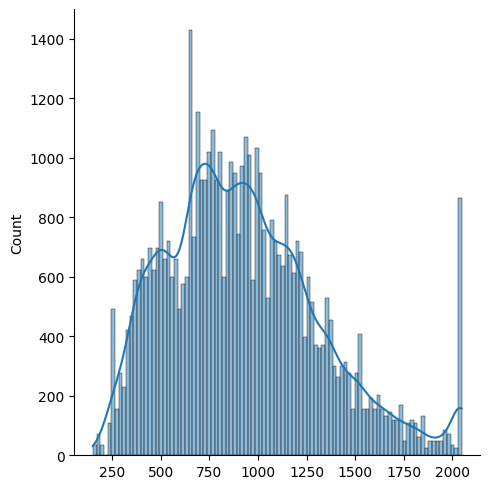

In [76]:
import seaborn as sns

#visualize the length of the songs

length = []
for song in dataset:
    length.append(len(song))
    
sns.displot(length, kde=True, bins=100)

In [77]:
print(dataset[0][:512])

['<style>', 'Jazz', 'Tonality', 'C major', '<start>', '|', '.', '4.0', 'C', 'maj', '|', '.', '4.0', 'C', 'maj', '|', '.', '4.0', 'C#', 'o', '|', '.', '4.0', 'C#', 'o', '|', '.', '4.0', 'D', 'm7', '|', '.', '4.0', 'G', 'dom7', '|', '.', '4.0', 'C', 'maj', '|', '.', '4.0', 'C', 'maj', '|', '.', '4.0', 'C', 'maj', '|', '.', '4.0', 'C', 'maj', '|', '.', '4.0', 'C#', 'o', '|', '.', '4.0', 'C#', 'o', '|', '.', '4.0', 'D', 'm7', '|', '.', '4.0', 'G', 'dom7', '|', '.', '4.0', 'C', 'maj', '|', '.', '2.0', 'F#', 'm7', '.', '2.0', 'B', 'dom7', '|', '.', '4.0', 'E', 'maj', '|', '.', '2.0', 'F#', 'm7', '.', '2.0', 'B', 'dom7', '|', '.', '4.0', 'E', 'maj', '|', '.', '2.0', 'F#', 'm7', '.', '2.0', 'B', 'dom7', '|', '.', '4.0', 'E', 'm7', '|', '.', '4.0', 'A', 'dom7', '|', '.', '4.0', 'D', 'dom7', '|', '.', '4.0', 'G', 'dom7', '|', '.', '4.0', 'C', 'maj', '|', '.', '4.0', 'C', 'maj', '|', '.', '4.0', 'Eb', 'o', '|', '.', '4.0', 'Eb', 'o', '|', '.', '4.0', 'D', 'm7', '|', '.', '4.0', 'G', 'dom7', '|', 

In [78]:
#Add the <pad> token to the dataset and to the midi_voicing_dataset, max length is 1024
length = 2048

for i, song in enumerate(dataset):
    if len(song) < length:
        for j in range(length - len(song)):
            song.append('<pad>')

for i, song in enumerate(midi_dataset):
    if len(song) < length:
        for j in range(length - len(song)):
            song.append([0, 0, 0, 0, 0, 0, 0, 0])

print(len(dataset), len(midi_dataset))
    

48072 48072


In [79]:
import numpy as np
dataset = np.array(dataset, dtype=object)
midi_dataset = np.array(midi_dataset, dtype=object)
meta_augmented = np.array(meta_augmented, dtype=object)
print(dataset.shape, midi_dataset.shape, meta_augmented.shape)

#save the dataset
np.save('../data/formatted/dataset.npy', dataset)
np.save('../data/formatted/midi_dataset.npy', midi_dataset)
np.save('../data/formatted/meta_augmented.npy', meta_augmented)


(48072, 2048) (48072, 2048, 8) (48072,)
